<a href="https://colab.research.google.com/github/ouhenio/en2ru-DALLE_notebook/blob/add-cache-update/en2ru_DALLE_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **en2ru-DALLE 🖼️**

## Generate images from text prompts using Sber AI's [ru-DALLE](https://github.com/sberbank-ai/ru-dalle) model.

ru-DALLE is a 1.3 billion parameter model from Sberbank-AI for Russian laguage, recreating [OpenAI's DALL·E](https://openai.com/blog/dall-e/), a model capable of generating arbitrary images from a text prompt that describes the desired result. 

The code here is taken from Sberbank AI's [example Colab](https://colab.research.google.com/drive/1wGE-046et27oHvNlBNPH07qrEQNE04PQ?usp=sharing), and adapted by [Eugenio Herrera](https://github.com/ouhenio) for a friendlier interace and allow to input English prompts (later translated to Russian). 

All credits go to the original creators.

In [1]:
#@markdown #**Check GPU, RAM and correct libraries versions** 🕵️
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---

#@markdown ru-DALLE requires a lot of computation, so GPU's besides
#@markdown V100, P100 and T4 are not recommended (unless you have a lot of time).
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.9.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Wed Nov  3 18:47:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

In [1]:
#@markdown #**Install and setup libraries** 🏗️
# @markdown This may take a little while because it has to download and setup the required libraries.

#@markdown ---

!pip install rudalle==0.0.1rc4 > /dev/null
!pip install translate

from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything
from translate import Translator

device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to(device)

Downloading:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


Downloading:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

x4 --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

ruclip --> ready


In [2]:
#@markdown #**Define necessary functions** 🛠️

translator = Translator(to_lang="ru")

"Translates prompt from english to russian."
def en_to_ru_translation(prompt):
    return translator.translate(prompt)

In [5]:
#@markdown #**Parameters** ✍️

#@markdown Notice that the prompts will be translated to Russian,
#@markdown meaning that **the intended prompt may be lost in translation**.

text = "a beatiful painting of a sunset"#@param {type:"string"}
top_k = 512#@param {type:"number"}
seed = 42#@param {type:"number"}
top_p = 0.995#@param {type:"number"}
images_num = 1#@param {type:"number"}

text = en_to_ru_translation(text)

In [6]:
#@markdown #**Run the model** 🚀

pil_images = []
scores = []

seed_everything(seed)

_pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
pil_images += _pil_images
scores += _scores

# for top_k, top_p, images_num in [
#     # (2048, 0.995, 3),
#     # (1536, 0.99, 3),
#     # (1024, 0.99, 3),
#     # (1024, 0.98, 3),
#     # (512, 0.97, 3),
#     # (384, 0.96, 3),
#     # (256, 0.95, 3),
#     (128, 0.95, 3)
# ]:
#     _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
#     pil_images += _pil_images
#     scores += _scores

100%|██████████| 1024/1024 [00:49<00:00, 20.68it/s]


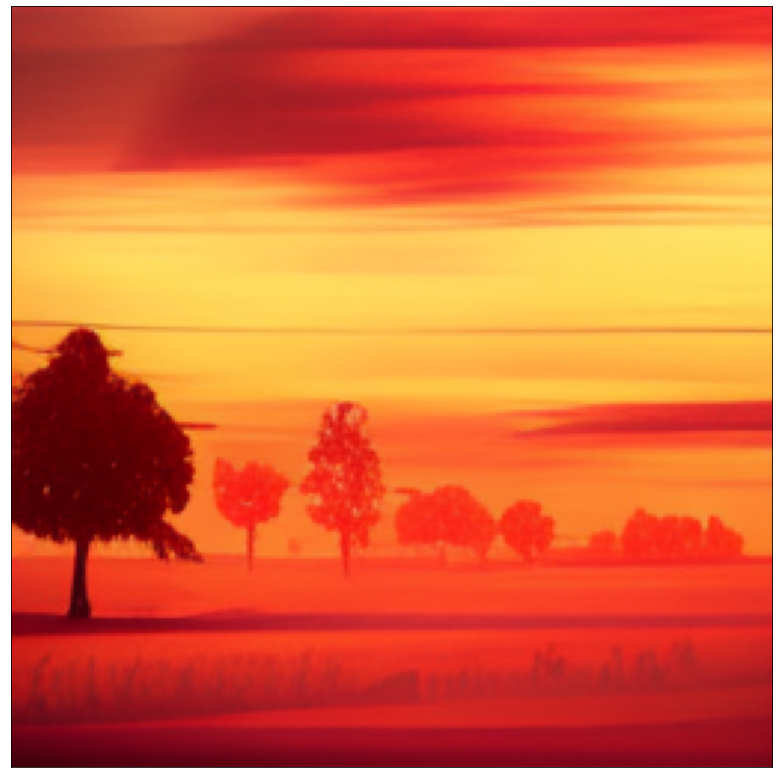

In [7]:
#@markdown #**Show images** 🚀

show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])] , 6)

### auto-cherry-pick by ruCLIP

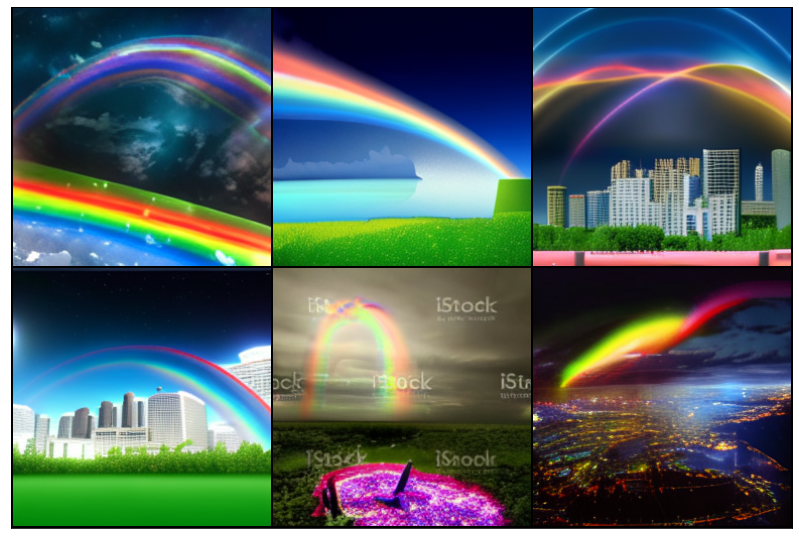

In [ ]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=6)
show(top_images, 3)

## super resolution

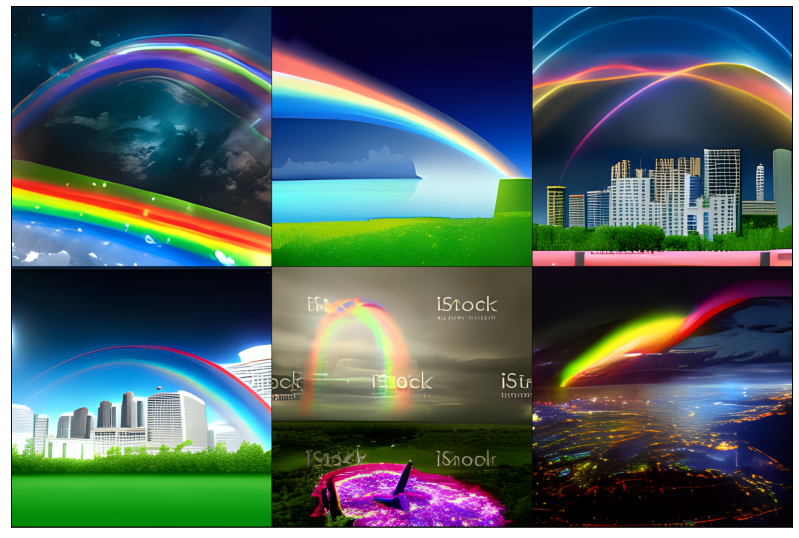

In [ ]:
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 3)